#**PROJECT 7**
#**Plant Seedlings Image Classification using CNN**
##**Aaron Coteff 3.13.2021**
###**GreatLearning AI/ML**



Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import PIL
import PIL.Image
import itertools
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import convolve2d 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from glob import glob
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [3]:
print(tf.__version__)

2.4.1


Load Data

In [4]:
path = '/content/drive/MyDrive/train/*/*.png'
files = glob(path)
num = len(files)
j = 1
trainImg = []
trainLabel = []


Reshape Data

In [5]:
for img in files:
    print(str(j) + '/' + str(num), end='\r')
    trainImg.append(cv2.resize(cv2.imread(img), (128, 128)))
    trainLabel.append(img.split('/')[-2])
    j += 1

trainImg = np.asarray(trainImg)
trainLabel = pd.DataFrame(trainLabel)

Print Shape Of Data

In [6]:
print('Images Shape:', trainImg.shape)
print('Labels Shape:', trainLabel.shape)
print(trainImg.shape[0], 'Image Samples')

Images Shape: (4753, 128, 128, 3)
Labels Shape: (4753, 1)
4753 Image Samples


In [7]:
dataset = r'/content/drive/MyDrive/train'
raw_data_dir = pathlib.Path(dataset)
dataset_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset, seed = 42)

Found 4753 files belonging to 12 classes.


In [8]:
class_names = dataset_ds.class_names
for i in class_names:
    print(i)

Black-grass
Charlock
Cleavers
Common Chickweed
Common wheat
Fat Hen
Loose Silky-bent
Maize
Scentless Mayweed
Shepherds Purse
Small-flowered Cranesbill
Sugar beet


In [9]:
label_dict = {
    'Black-grass': 0,
    'Charlock': 1,
    'Cleavers': 2,
    'Common Chickweed': 3,
    'Common wheat': 4,
    'Fat Hen': 5,
    'Loose Silky-bent': 6,
    'Maize': 7,
    'Scentless Mayweed': 8,
    'Shepherds Purse': 9,
    'Small-flowered Cranesbill': 10,
    'Sugar beet': 11
}


Visualize Images In Dataset

An assortment of seedling images:


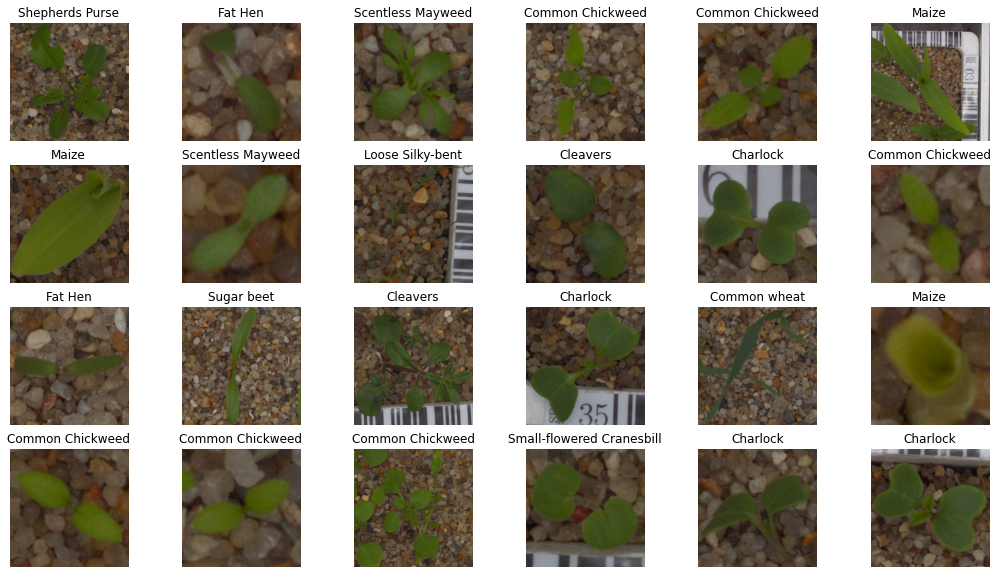

In [10]:
print('An assortment of seedling images:')
plt.figure(figsize=(18, 10))
for images, labels in dataset_ds.take(1):
  for i in range(24):
    ax = plt.subplot(4, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
black_grass = list(raw_data_dir.glob('Black-grass/*'))
charlock = list(raw_data_dir.glob('Charlock/*'))
cleavers = list(raw_data_dir.glob('Cleavers/*'))
common_chickweed = list(raw_data_dir.glob('Common Chickweed/*'))
common_wheat = list(raw_data_dir.glob('Common wheat/*'))
fat_hen = list(raw_data_dir.glob('Fat Hen/*'))
loose_silky_bent = list(raw_data_dir.glob('Loose Silky-bent/*'))
maize = list(raw_data_dir.glob('Maize/*'))
scentless_mayweed = list(raw_data_dir.glob('Scentless Mayweed/*'))
shepherds_purse = list(raw_data_dir.glob('Shepherds Purse/*'))
small_flowered_cranesbill = list(raw_data_dir.glob('Small-flowered Cranesbill/*'))
sugar_beet = list(raw_data_dir.glob('Sugar beet/*'))

Black-Grass:


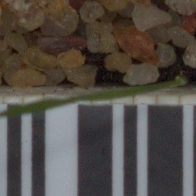

In [12]:
print('Black-Grass:')
PIL.Image.open(str(black_grass[0]))

Charlock:


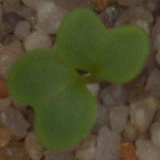

In [13]:
print('Charlock:')
PIL.Image.open(str(charlock[0]))

Cleavers:


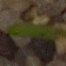

In [14]:
print('Cleavers:')
PIL.Image.open(str(cleavers[0]))

Common Chickweed:


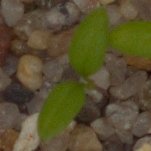

In [15]:
print('Common Chickweed:')
PIL.Image.open(str(common_chickweed[0]))

Common Wheat:


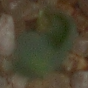

In [16]:
print('Common Wheat:')
PIL.Image.open(str(common_wheat[0]))

Fat Hen:


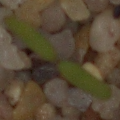

In [17]:
print('Fat Hen:')
PIL.Image.open(str(fat_hen[0]))

Loose Silky-Bent:


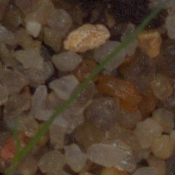

In [18]:
print('Loose Silky-Bent:')
PIL.Image.open(str(loose_silky_bent[0]))

Maize:


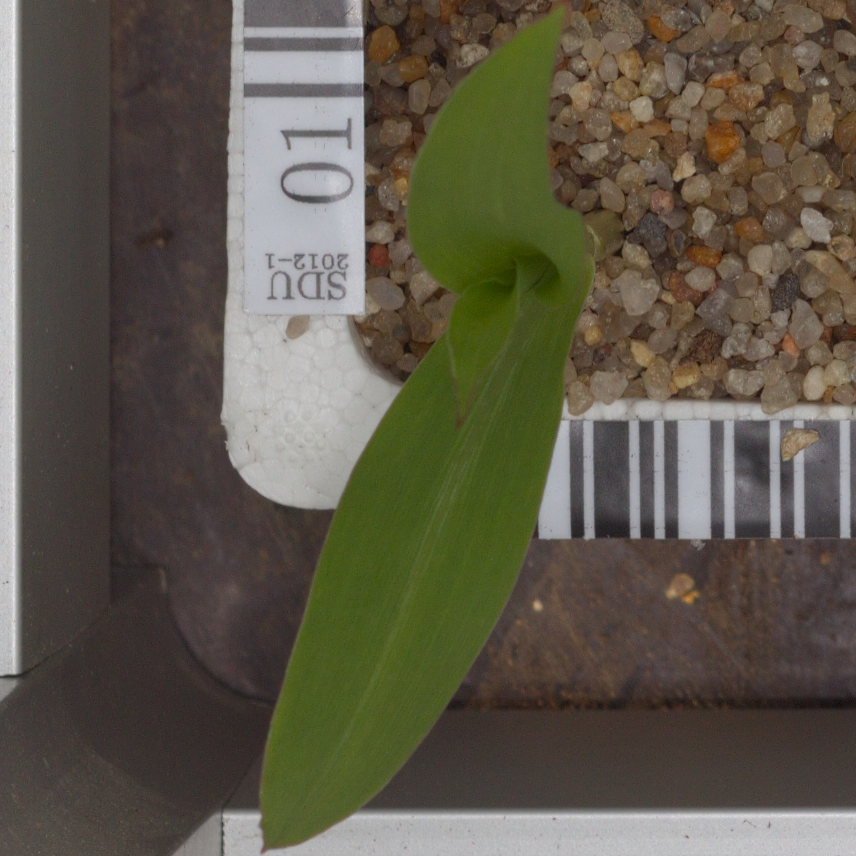

In [19]:
print('Maize:')
PIL.Image.open(str(maize[0]))

Scentless Mayweed:


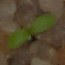

In [20]:
print('Scentless Mayweed:')
PIL.Image.open(str(scentless_mayweed[0]))

Shepherds Purse:


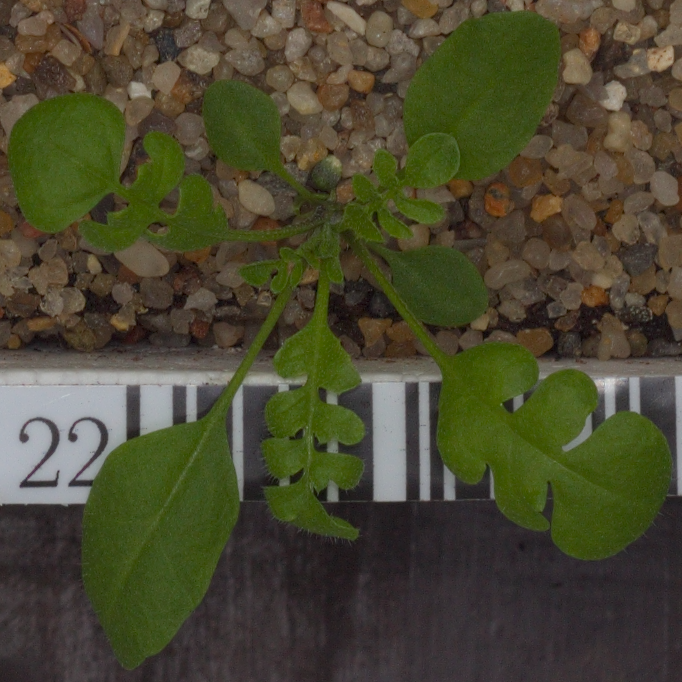

In [21]:
print('Shepherds Purse:')
PIL.Image.open(str(shepherds_purse[0]))

Small-Flowered Cranesbill:


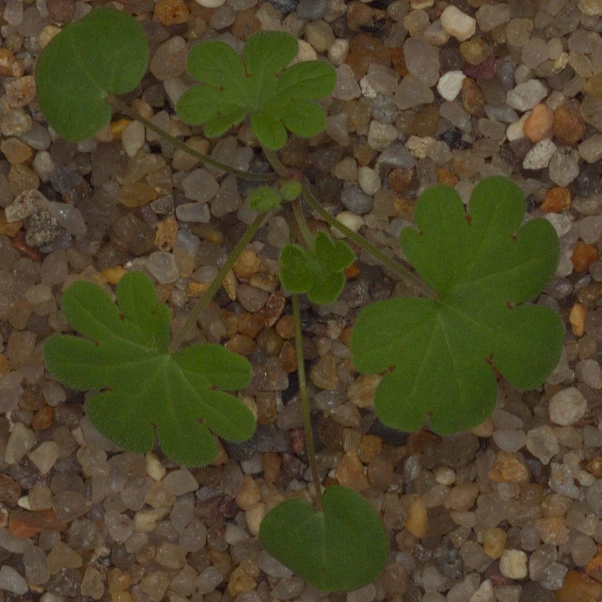

In [22]:
print('Small-Flowered Cranesbill:')
PIL.Image.open(str(small_flowered_cranesbill[0]))

Sugar Beet:


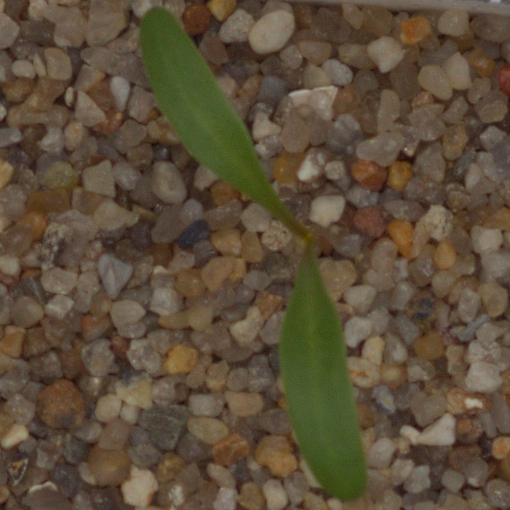

In [23]:
print('Sugar Beet:')
PIL.Image.open(str(sugar_beet[0]))

Pre-Processing: Normalization

In [24]:
norm_trainImg = trainImg/255

In [25]:
trainImg

array([[[[ 48,  64,  80],
         [ 44,  60,  78],
         [ 42,  58,  75],
         ...,
         [ 68,  77,  81],
         [ 68,  76,  81],
         [ 68,  76,  82]],

        [[ 43,  59,  77],
         [ 41,  57,  76],
         [ 40,  56,  73],
         ...,
         [ 74,  80,  86],
         [ 69,  77,  83],
         [ 67,  75,  83]],

        [[ 35,  51,  72],
         [ 37,  51,  71],
         [ 41,  54,  73],
         ...,
         [ 72,  80,  88],
         [ 68,  78,  87],
         [ 64,  75,  87]],

        ...,

        [[ 28,  39,  54],
         [ 32,  45,  60],
         [ 31,  47,  61],
         ...,
         [ 42,  48,  59],
         [ 36,  42,  54],
         [ 37,  42,  55]],

        [[ 10,  19,  38],
         [ 19,  31,  47],
         [ 20,  37,  51],
         ...,
         [ 52,  58,  70],
         [ 49,  53,  66],
         [ 30,  33,  50]],

        [[  1,   5,  26],
         [  5,  16,  34],
         [  9,  27,  40],
         ...,
         [ 47,  53,  66],
        

In [26]:
norm_trainImg

array([[[[0.18823529, 0.25098039, 0.31372549],
         [0.17254902, 0.23529412, 0.30588235],
         [0.16470588, 0.22745098, 0.29411765],
         ...,
         [0.26666667, 0.30196078, 0.31764706],
         [0.26666667, 0.29803922, 0.31764706],
         [0.26666667, 0.29803922, 0.32156863]],

        [[0.16862745, 0.23137255, 0.30196078],
         [0.16078431, 0.22352941, 0.29803922],
         [0.15686275, 0.21960784, 0.28627451],
         ...,
         [0.29019608, 0.31372549, 0.3372549 ],
         [0.27058824, 0.30196078, 0.3254902 ],
         [0.2627451 , 0.29411765, 0.3254902 ]],

        [[0.1372549 , 0.2       , 0.28235294],
         [0.14509804, 0.2       , 0.27843137],
         [0.16078431, 0.21176471, 0.28627451],
         ...,
         [0.28235294, 0.31372549, 0.34509804],
         [0.26666667, 0.30588235, 0.34117647],
         [0.25098039, 0.29411765, 0.34117647]],

        ...,

        [[0.10980392, 0.15294118, 0.21176471],
         [0.1254902 , 0.17647059, 0.23529412]

Pre-Processing: Gaussian Blurring

In [27]:
blurred_trainImg = gaussian_filter(norm_trainImg, sigma = .5)

Before/After

Loose Silky-bent


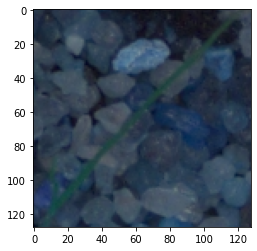

Processed Loose Silky-bent


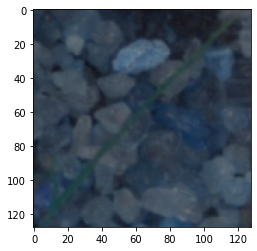

Loose Silky-bent


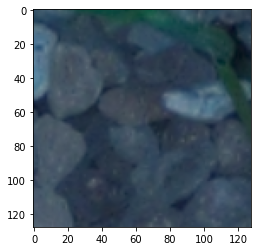

Processed Loose Silky-bent


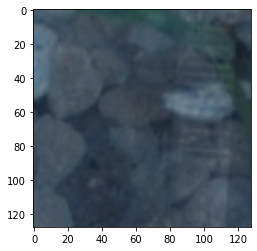

Common wheat


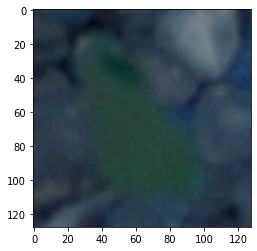

Processed Common wheat


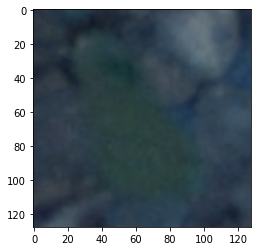

Black-grass


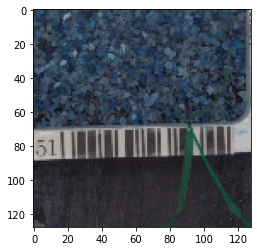

Processed Black-grass


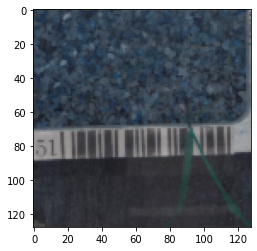

Sugar beet


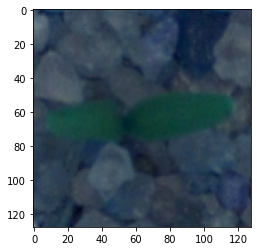

Processed Sugar beet


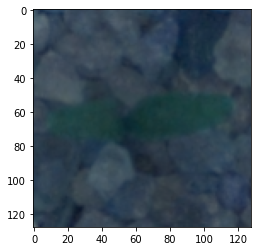

Small-flowered Cranesbill


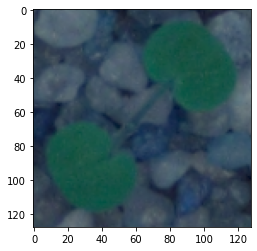

Processed Small-flowered Cranesbill


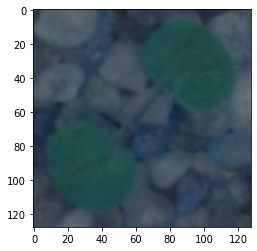

Fat Hen


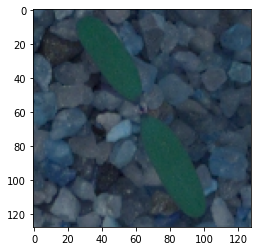

Processed Fat Hen


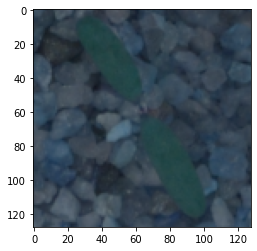

Fat Hen


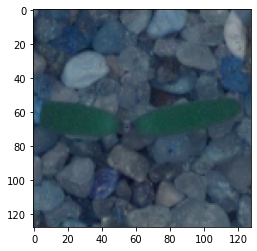

Processed Fat Hen


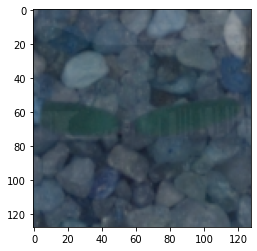

Common Chickweed


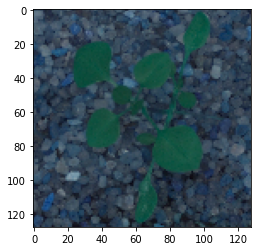

Processed Common Chickweed


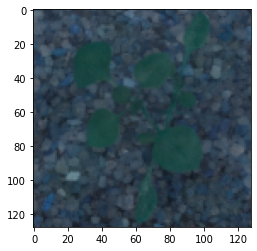

Common Chickweed


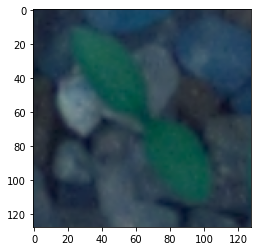

Processed Common Chickweed


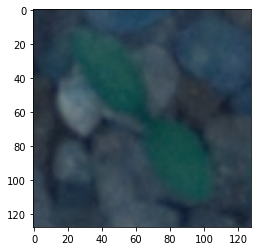

Scentless Mayweed


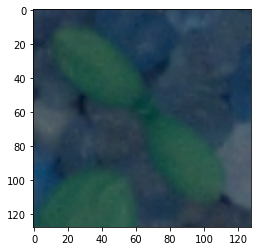

Processed Scentless Mayweed


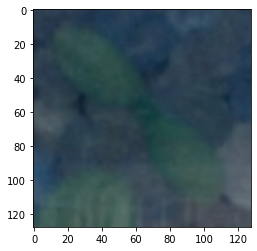

Maize


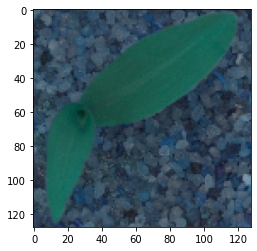

Processed Maize


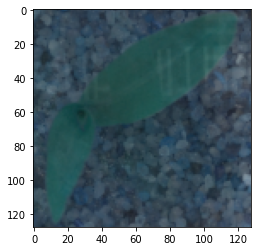

Charlock


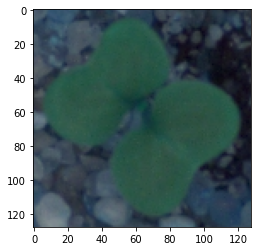

Processed Charlock


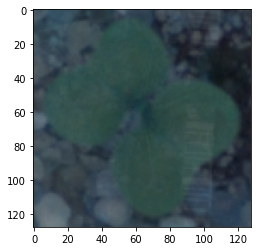

In [28]:
for i in range(0,4753, 395):
    print(trainLabel[0][i])
    plt.imshow(trainImg[i]);
    plt.show()
    print('Processed', trainLabel[0][i])
    plt.imshow(blurred_trainImg[i]);
    plt.show()
    

Split Data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(blurred_trainImg, trainLabel, test_size = .3, random_state = 42)

In [30]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = .5, random_state = 42)

In [31]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3327, 128, 128, 3)
(713, 128, 128, 3)
(713, 128, 128, 3)


In [33]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3327, 1)
(713, 1)
(713, 1)


Convert Labels

In [34]:
enc = LabelBinarizer()
y_train = enc.fit_transform(y_train)
y_val = enc.fit_transform(y_val)
y_test = enc.fit_transform(y_test)

In [35]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3327, 12)
(713, 12)
(713, 12)


[0 0 0 0 0 0 0 0 1 0 0 0]


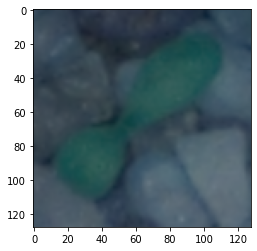

In [38]:
print(y_train[0])
plt.imshow(X_train[0]);

Define Layers

In [41]:
num_classes = 12

model = tf.keras.Sequential([
    layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Conv2D(64, (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Conv2D(64, (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation = 'softmax')
])



Set Optimizer & Loss Function

In [44]:
model.compile(
  optimizer='adam',
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

In [49]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [56]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10)

In [59]:
checkpoint_filepath = '/tmp/checkpoint'

In [62]:
model_checkpoint =  ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = 'auto',
    save_freq = 1
)

Fit Model

In [63]:
history = model.fit(
    X_train,
    y_train,
    batch_size= 32,
    epochs= 40,
    validation_data= (X_val, y_val),
    shuffle= True,
    verbose = 1,
    callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/40
  1/104 [..............................] - ETA: 3:42 - loss: 0.2897 - accuracy: 0.8438
Epoch 00001: accuracy improved from -inf to 0.84375, saving model to /tmp/checkpoint
  2/104 [..............................] - ETA: 3:44 - loss: 0.2371 - accuracy: 0.9062
Epoch 00001: accuracy improved from 0.84375 to 0.90625, saving model to /tmp/checkpoint
  3/104 [..............................] - ETA: 3:41 - loss: 0.2089 - accuracy: 0.9271
Epoch 00001: accuracy improved from 0.90625 to 0.92708, saving model to /tmp/checkpoint
  4/104 [>.............................] - ETA: 3:37 - loss: 0.1995 - accuracy: 0.9297
Epoch 00001: accuracy improved from 0.92708 to 0.92969, saving model to /tmp/checkpoint
  5/104 [>.............................] - ETA: 3:35 - loss: 0.2651 - accuracy: 0.9125
Epoch 00001: accuracy did not improve from 0.92969
  6/104 [>.............................] - ETA: 3:32 - loss: 0.2688 - accuracy: 0.9115
Epoch 00001: accuracy did not improve from 0.92969
  7/104 [=>.....

Evaluate Model

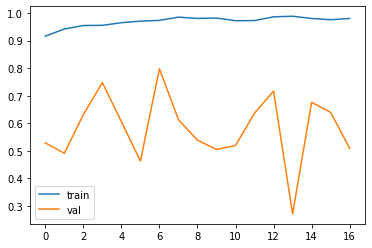

In [64]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [66]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 12s 501ms/step - loss: 3.5066 - accuracy: 0.5161
Test loss: 3.5066261291503906
Test accuracy: 0.5161290168762207


In [67]:
model.predict(X_test)

array([[5.99364996e-01, 3.63414192e-15, 8.90734064e-09, ...,
        1.04909029e-13, 1.20048806e-11, 5.03962383e-06],
       [9.52449369e-11, 6.38363866e-17, 2.01464583e-12, ...,
        3.07628163e-13, 1.42433496e-11, 1.52546249e-06],
       [2.90294829e-05, 3.33100930e-02, 3.39594949e-03, ...,
        7.63530579e-07, 4.92129963e-08, 5.91036916e-01],
       ...,
       [9.99982834e-01, 1.53937712e-18, 5.94155697e-11, ...,
        1.90073228e-14, 7.89099797e-13, 1.33326816e-09],
       [9.91294980e-01, 7.44360272e-15, 5.27143129e-12, ...,
        1.83505433e-13, 9.08287405e-15, 1.09782478e-11],
       [1.27300216e-13, 2.68710713e-21, 2.84205033e-14, ...,
        5.56476116e-14, 5.80019886e-12, 1.65396816e-08]], dtype=float32)

In [73]:
model.predict(X_test[:4])

array([[5.99364758e-01, 3.63414065e-15, 8.90737084e-09, 7.07806591e-11,
        1.65583522e-04, 2.94740498e-03, 3.97517234e-01, 4.31604622e-14,
        1.37422074e-10, 1.04909184e-13, 1.20048763e-11, 5.03963656e-06],
       [9.52451173e-11, 6.38366248e-17, 2.01464583e-12, 9.17055494e-12,
        1.16640286e-13, 9.99998450e-01, 5.78975146e-10, 6.32384475e-17,
        4.49181525e-11, 3.07628163e-13, 1.42433773e-11, 1.52546249e-06],
       [2.90294702e-05, 3.33100334e-02, 3.39595135e-03, 1.18102971e-05,
        1.26011830e-04, 3.71876955e-01, 1.33585359e-04, 1.46388246e-07,
        7.90794875e-05, 7.63529613e-07, 4.92129750e-08, 5.91036677e-01],
       [3.28431571e-09, 1.25655442e-09, 9.99896646e-01, 1.81090562e-13,
        3.78191908e-05, 1.29786812e-07, 3.83355223e-11, 8.49723304e-21,
        1.62319008e-12, 6.45362127e-14, 3.67998987e-14, 6.54659671e-05]],
      dtype=float32)

In [74]:
y_test[:4]

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [79]:
predictions = np.round(model.predict(X_test), 0)
print('Rounded Test Labels:\n', predictions)

Rounded Test Labels:
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [85]:
classification_metrics = metrics.classification_report(y_test, predictions, target_names = class_names)
print(classification_metrics)

                           precision    recall  f1-score   support

              Black-grass       0.33      0.63      0.43        38
                 Charlock       0.93      0.46      0.62        56
                 Cleavers       0.75      0.75      0.75        53
         Common Chickweed       0.91      0.45      0.60        92
             Common wheat       0.55      0.26      0.35        42
                  Fat Hen       0.20      0.60      0.30        60
         Loose Silky-bent       0.56      0.76      0.64       100
                    Maize       1.00      0.15      0.26        40
        Scentless Mayweed       0.83      0.28      0.42        72
          Shepherds Purse       0.38      0.25      0.30        32
Small-flowered Cranesbill       1.00      0.44      0.61        70
               Sugar beet       0.56      0.78      0.65        58

                micro avg       0.52      0.51      0.52       713
                macro avg       0.67      0.48      0.50    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [128]:
categorical_test_labels = pd.DataFrame(y_test).idxmax(axis=1)
categorical_preds = pd.DataFrame(predictions).idxmax(axis=1)

Confusion Matrix

In [121]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 12))
    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = class_names, yticklabels = class_names, cmap= plt.cm.Blues)
    plt.title('CONFUSION MATRIX')
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

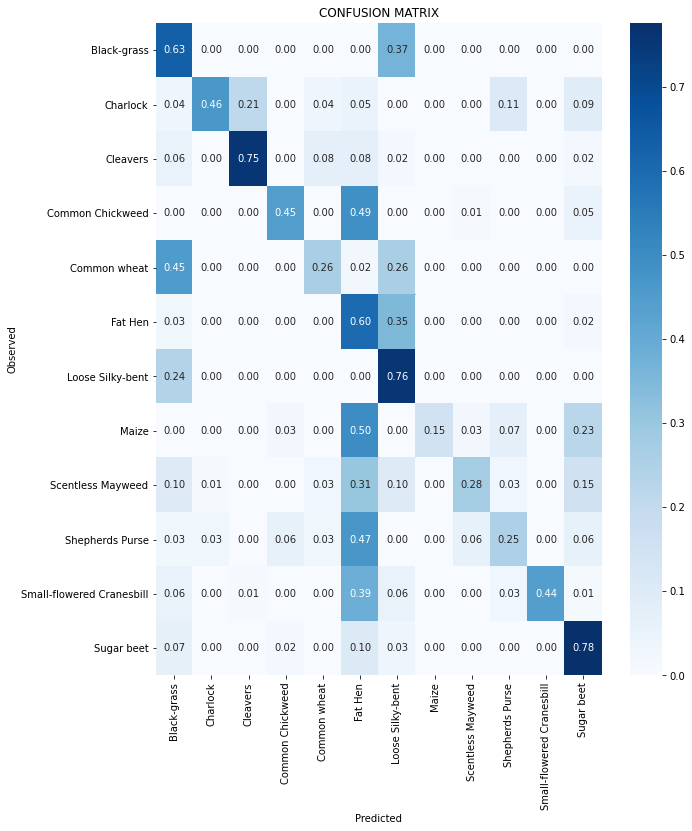

In [122]:
plot_confusion_matrix(confusion_matrix, class_names)

Visualize Predictions

In [136]:
visualize_predictions = [2, 3, 33, 36, 59]

X_test[ 2 ] Visualized:

Predicted:  11
Actual: 1
[0 1 0 0 0 0 0 0 0 0 0 0]


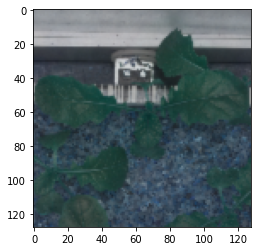



X_test[ 3 ] Visualized:

Predicted:  2
Actual: 2
[0 0 1 0 0 0 0 0 0 0 0 0]


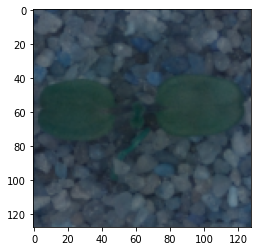



X_test[ 33 ] Visualized:

Predicted:  0
Actual: 11
[0 0 0 0 0 0 0 0 0 0 0 1]


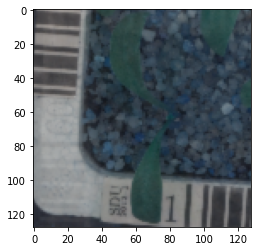



X_test[ 36 ] Visualized:

Predicted:  6
Actual: 5
[0 0 0 0 0 1 0 0 0 0 0 0]


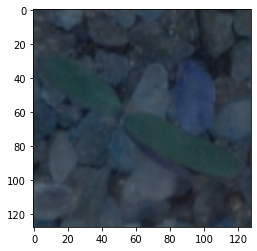



X_test[ 59 ] Visualized:

Predicted:  6
Actual: 6
[0 0 0 0 0 0 1 0 0 0 0 0]


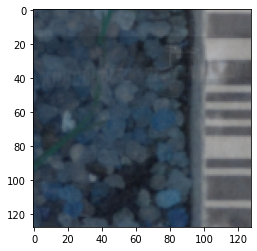

In [140]:
for i in visualize_predictions:
    print('X_test[', i, '] Visualized:')
    print()
    print('Predicted: ', categorical_preds[i])
    print('Actual:', categorical_test_labels[i])
    print(y_test[i])
    plt.imshow(X_test[i]);
    plt.show()
    print()
    print()